In [1]:
import sys
sys.path.append('/mnt/d/ariel2/code/core/')
sys.path.append('d:/ariel2/code/core/')
sys.path.append('/kaggle/input/my-ariel2-library')
import kaggle_support as kgs
import ariel_model
import ariel_simple
import ariel_gp
import ariel_load
import ariel_load_FGS
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
kgs.debugging_mode = 1

local


In [2]:
train_data = kgs.load_all_train_data()
train_data = train_data

In [3]:
todo = dict()

model = ariel_model.Fudger(model=ariel_gp.PredictionModel())
model.model.run_in_parallel = True
#todo['Baseline GP'] = model

# model = ariel_model.Fudger(model=ariel_gp.PredictionModel())
# model.model.run_in_parallel = True
# todo['Baseline GP chk'] = model

model = ariel_model.Fudger(model=ariel_gp.PredictionModel())
model.model.run_in_parallel = True
loaders = model.model.starter_model.loaders
loaders[0].apply_wavelength_binning = ariel_load_FGS.ApplyWavelengthBinningFGS2()
loaders[0].apply_wavelength_binning.n_mean_pixels = 0
loaders[0].apply_pixel_corrections.mask_hot = False
loaders[0].apply_full_sensor_corrections.inpainting_2d = False
loaders[0].apply_full_sensor_corrections.restore_invalids = False
loaders[0].apply_full_sensor_corrections.remove_background_based_on_pixels = False
todo['New FGS'] = model

model = ariel_model.Fudger(model=ariel_gp.PredictionModel())
model.model.run_in_parallel = True
loaders = model.model.starter_model.loaders
loaders[0].apply_wavelength_binning = ariel_load_FGS.ApplyWavelengthBinningFGS2()
loaders[0].apply_wavelength_binning.n_mean_pixels = 0
loaders[0].apply_pixel_corrections.mask_hot = False
loaders[0].apply_full_sensor_corrections.inpainting_2d = True
loaders[0].apply_full_sensor_corrections.restore_invalids = True
loaders[0].apply_full_sensor_corrections.remove_background_based_on_pixels = True
todo['New FGS mf'] = model

model = ariel_model.Fudger(model=ariel_gp.PredictionModel())
model.model.run_in_parallel = True
loaders = model.model.starter_model.loaders
loaders[0].apply_wavelength_binning = ariel_load_FGS.ApplyWavelengthBinningFGS2()
loaders[0].apply_wavelength_binning.n_mean_pixels = 0
loaders[0].apply_pixel_corrections.mask_hot = False
loaders[0].apply_full_sensor_corrections.inpainting_2d = True
loaders[0].apply_full_sensor_corrections.restore_invalids = True
loaders[0].apply_full_sensor_corrections.remove_background_based_on_pixels = True
model.model.model_options.FGS_order = 3
todo['New FGS mf+ poly FGS'] = model


# model = ariel_model.Fudger(model=ariel_gp.PredictionModel())
# loaders = model.model.starter_model.loaders
# loaders[1].apply_full_sensor_corrections.inpainting_wavelength = False
# loaders[1].apply_pixel_corrections.mask_hot = False
# loaders[1].apply_full_sensor_corrections.use_pca_for_background_removal = False
# loaders[1].apply_full_sensor_corrections.remove_background_based_on_rows = False
# loaders[1].apply_full_sensor_corrections.remove_background_remove_used_rows = False
# loaders[1].apply_wavelength_binning = ariel_load.ApplyWavelengthBinningAIRS2()
# loaders[1].apply_wavelength_binning.make_diagnostic_plots = False
# loaders[1].apply_wavelength_binning.residual_threshold = np.inf
# model.model.run_in_parallel = True
# todo['New AIRS no residual threshold'] = model

# model = ariel_model.Fudger(model=ariel_gp.PredictionModel())
# loaders = model.model.starter_model.loaders
# loaders[1].apply_full_sensor_corrections.inpainting_wavelength = False
# loaders[1].apply_pixel_corrections.mask_hot = False
# loaders[1].apply_full_sensor_corrections.use_pca_for_background_removal = False
# loaders[1].apply_full_sensor_corrections.remove_background_based_on_rows = False
# loaders[1].apply_full_sensor_corrections.remove_background_remove_used_rows = False
# loaders[1].apply_wavelength_binning = ariel_load.ApplyWavelengthBinningAIRS2()
# loaders[1].apply_wavelength_binning.make_diagnostic_plots = False
# loaders[1].apply_wavelength_binning.residual_threshold = 50
# model.model.run_in_parallel = True
# todo['New AIRS residual threshold 50'] = model

In [4]:
kgs.sanity_checks_active = True
def fname(k):
    return kgs.temp_dir + 'evaluate_model_'+k+'__'+str(len(train_data))+'.pickle'
for k,v in todo.items():
    if not os.path.isfile(fname(k)):
        print(k)
        model = copy.deepcopy(v)
        
        # Precache data
        for d in tqdm(train_data):
            copy.deepcopy(d).load_to_step(5,model.model.starter_model.loaders)
        
        
        model.train(train_data)
        inferred_data = model.infer(train_data)
        print(k)
        kgs.score_metric(inferred_data, train_data)
        kgs.dill_save(fname(k), (inferred_data,model,kgs.git_commit_id))
    else:
        print(k)
        (inferred_data,model,_) = kgs.dill_load(fname(k))
        kgs.score_metric(inferred_data, train_data)

New FGS
Score:          0.6079
RMS error FGS:  199.05 ppm
RMS error AIRS: 151.75 ppm
New FGS mf


Processing in parallel: 100%|█████████████████████████████████████████████████████| 1099/1099 [1:38:53<00:00,  5.40s/it]


local
SpawnPoolWorker-3 3
CUDA_VISIBLE_DEVICES= 0
local
SpawnPoolWorker-1 1
CUDA_VISIBLE_DEVICES= 0
local
SpawnPoolWorker-2 2
CUDA_VISIBLE_DEVICES= 0
Opt time 259.34303426742554
New FGS mf
Score:          0.6077
RMS error FGS:  196.67 ppm
RMS error AIRS: 148.92 ppm
New FGS mf+ poly FGS


Processing in parallel: 100%|█████████████████████████████████████████████████████| 1099/1099 [1:21:48<00:00,  4.47s/it]


local
SpawnPoolWorker-4 4
CUDA_VISIBLE_DEVICES= 0
local
SpawnPoolWorker-6 6
CUDA_VISIBLE_DEVICES= 0
local
SpawnPoolWorker-5 5
CUDA_VISIBLE_DEVICES= 0
Opt time 587.2517986297607
New FGS mf+ poly FGS
Score:          0.6071
RMS error FGS:  228.79 ppm
RMS error AIRS: 173.51 ppm


In [5]:
[len(d.transits) for d in train_data if d.planet_id in [1349926825, 3786449677, 2554492145, 1267010874, 94572221, 2270815333, 3649218579, 576917580, 2154305089, 2207815333, 2740910036]]

[1, 2, 1, 2, 1, 1, 2, 1, 2, 1]

New FGS
[1.002333100175582, 0.9983167307851899]
[-7.23512597550878e-07, 6.5440482075930455e-06]
[1.4570372659883712, 1.3457286066741945]
Score:          0.6079
RMS error FGS:  199.05 ppm
RMS error AIRS: 151.75 ppm

20
Score:          0.6280
RMS error FGS:  85.72 ppm
RMS error AIRS: 69.42 ppm

No fudge
Score:          0.5924
RMS error FGS:  199.05 ppm
RMS error AIRS: 151.75 ppm


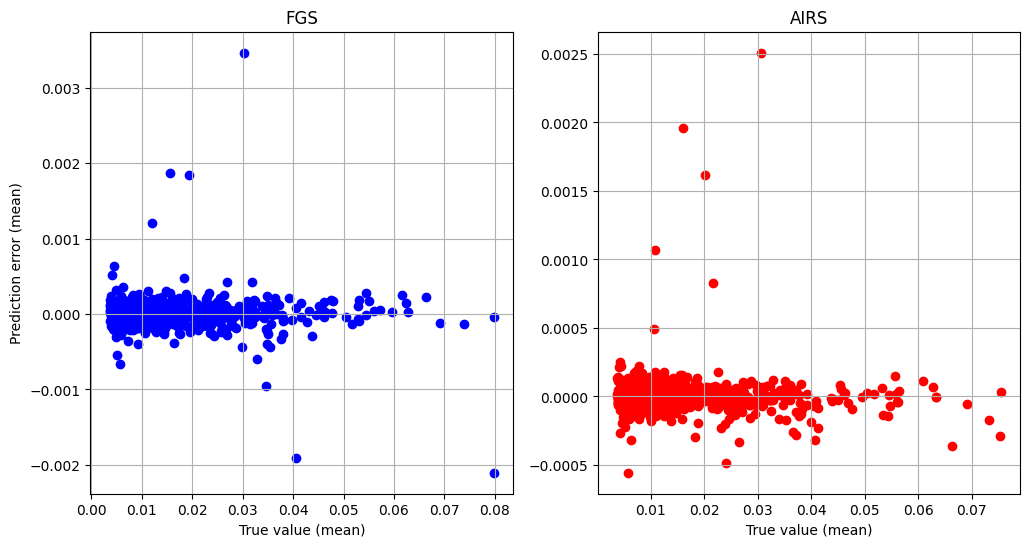

FGS
1349926825, ratio:19.439, x:1.082e-04, y:-2.104e-03, RMS:1.043e-03
3786449677, ratio:16.133, x:1.180e-04, y:-1.903e-03, RMS:5.512e-04
1267010874, ratio:9.946, x:9.539e-05, y:-9.487e-04, RMS:3.293e-04
94572221, ratio:9.761, x:6.849e-05, y:-6.685e-04, RMS:5.573e-04
2554492145, ratio:8.902, x:1.363e-04, y:1.213e-03, RMS:1.079e-03
3649218579, ratio:6.643, x:5.219e-04, y:3.467e-03, RMS:2.514e-03
2498341557, ratio:5.145, x:6.850e-05, y:-3.525e-04, RMS:1.212e-04
342072318, ratio:4.925, x:5.998e-05, y:-2.954e-04, RMS:1.037e-04
1338107575, ratio:4.796, x:1.143e-04, y:-5.483e-04, RMS:6.340e-05
1344395817, ratio:4.575, x:9.394e-05, y:-4.298e-04, RMS:6.846e-05
AIRS
94572221, ratio:13.252, x:4.201e-05, y:-5.568e-04, RMS:5.573e-04
2554492145, ratio:10.874, x:9.821e-05, y:1.068e-03, RMS:1.079e-03
2270815333, ratio:10.610, x:4.545e-05, y:-4.822e-04, RMS:1.047e-03
3649218579, ratio:10.230, x:2.452e-04, y:2.509e-03, RMS:2.514e-03
576917580, ratio:9.160, x:1.768e-04, y:1.619e-03, RMS:1.622e-03
346757

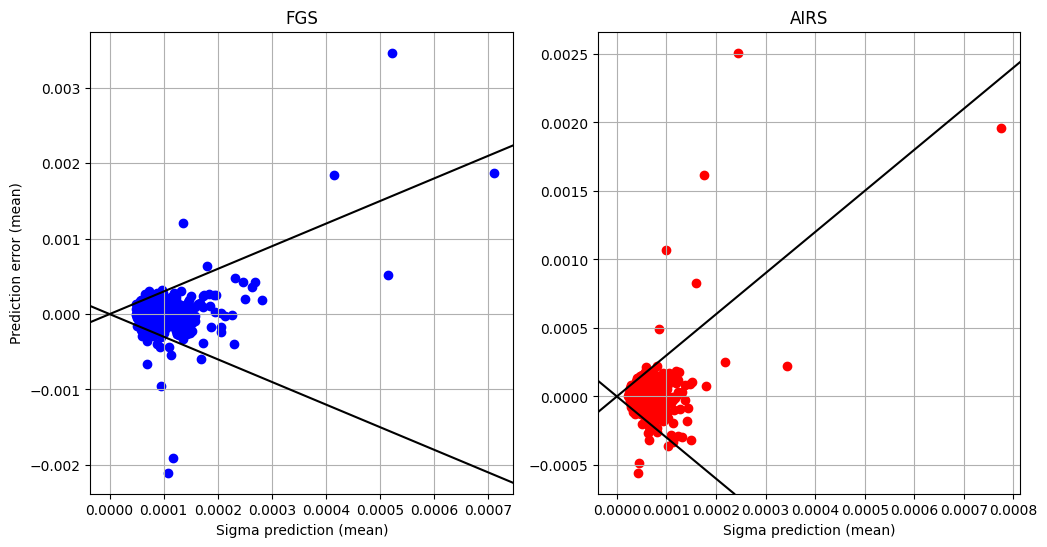

AIRS variation
1349926825, ratio:10.670, x:9.586e-05, y:1.023e-03, RMS:1.043e-03
2270815333, ratio:10.623, x:8.771e-05, y:9.318e-04, RMS:1.047e-03
2740910036, ratio:5.408, x:1.545e-05, y:8.355e-05, RMS:8.374e-05
926530491, ratio:4.406, x:1.594e-05, y:7.023e-05, RMS:1.163e-04
3786449677, ratio:4.254, x:1.032e-04, y:4.390e-04, RMS:5.512e-04
1843015807, ratio:4.044, x:1.603e-05, y:6.481e-05, RMS:1.958e-03
3196466205, ratio:3.653, x:1.452e-05, y:5.306e-05, RMS:9.982e-05
2364090646, ratio:3.598, x:1.609e-05, y:5.789e-05, RMS:3.003e-04
2617217319, ratio:3.403, x:1.510e-05, y:5.138e-05, RMS:5.246e-05
1470836017, ratio:3.283, x:8.652e-05, y:2.840e-04, RMS:2.843e-04


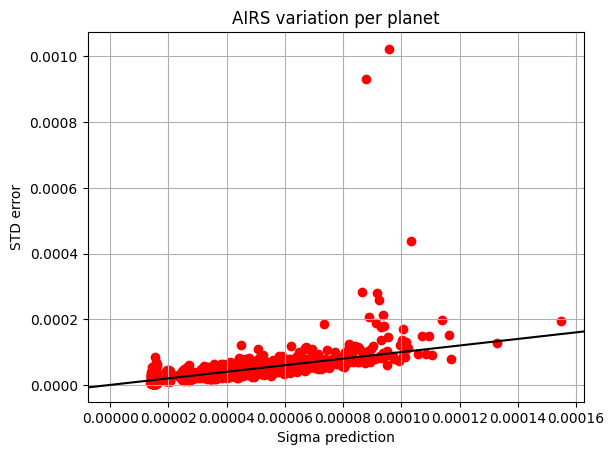

New FGS mf
[1.0000993552435251, 0.9983285878181615]
[-4.6804408657950246e-07, 6.586575657091392e-06]
[1.4504576695021179, 1.3467072700013778]
Score:          0.6077
RMS error FGS:  196.67 ppm
RMS error AIRS: 148.92 ppm

20
Score:          0.6280
RMS error FGS:  84.82 ppm
RMS error AIRS: 69.60 ppm

No fudge
Score:          0.5922
RMS error FGS:  196.67 ppm
RMS error AIRS: 148.92 ppm


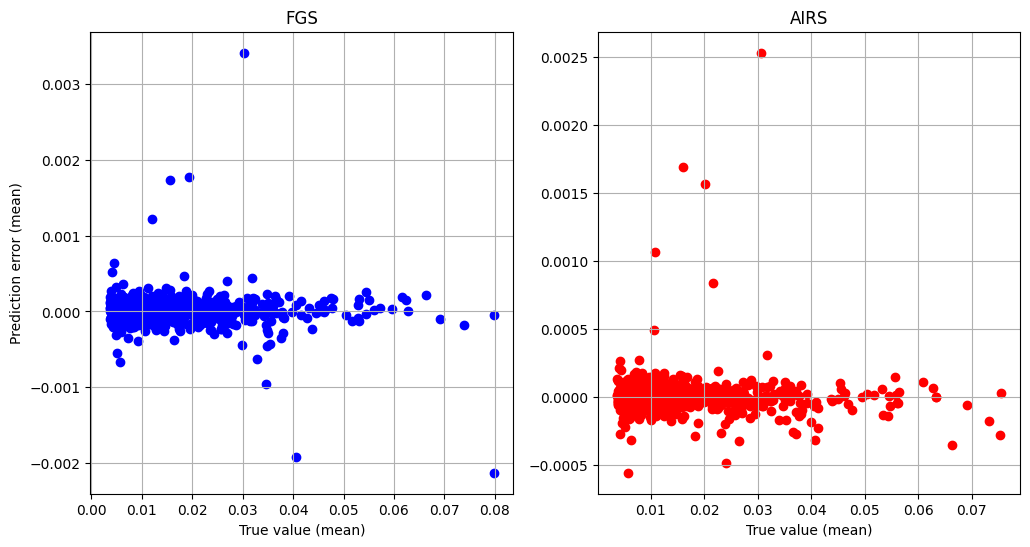

FGS
1349926825, ratio:19.024, x:1.118e-04, y:-2.126e-03, RMS:1.043e-03
3786449677, ratio:16.212, x:1.181e-04, y:-1.915e-03, RMS:5.515e-04
1267010874, ratio:10.011, x:9.550e-05, y:-9.560e-04, RMS:3.297e-04
94572221, ratio:9.760, x:6.856e-05, y:-6.691e-04, RMS:5.571e-04
2554492145, ratio:8.892, x:1.365e-04, y:1.213e-03, RMS:1.080e-03
3649218579, ratio:6.552, x:5.209e-04, y:3.413e-03, RMS:2.534e-03
2498341557, ratio:5.137, x:6.858e-05, y:-3.523e-04, RMS:1.211e-04
576917580, ratio:4.892, x:3.615e-04, y:1.769e-03, RMS:1.568e-03
342072318, ratio:4.873, x:6.008e-05, y:-2.928e-04, RMS:1.036e-04
1338107575, ratio:4.800, x:1.145e-04, y:-5.495e-04, RMS:6.384e-05
AIRS
94572221, ratio:13.247, x:4.201e-05, y:-5.566e-04, RMS:5.571e-04
2270815333, ratio:11.408, x:4.226e-05, y:-4.821e-04, RMS:1.047e-03
3649218579, ratio:10.312, x:2.453e-04, y:2.529e-03, RMS:2.534e-03
2554492145, ratio:9.560, x:1.118e-04, y:1.069e-03, RMS:1.080e-03
576917580, ratio:8.581, x:1.824e-04, y:1.566e-03, RMS:1.568e-03
34675798

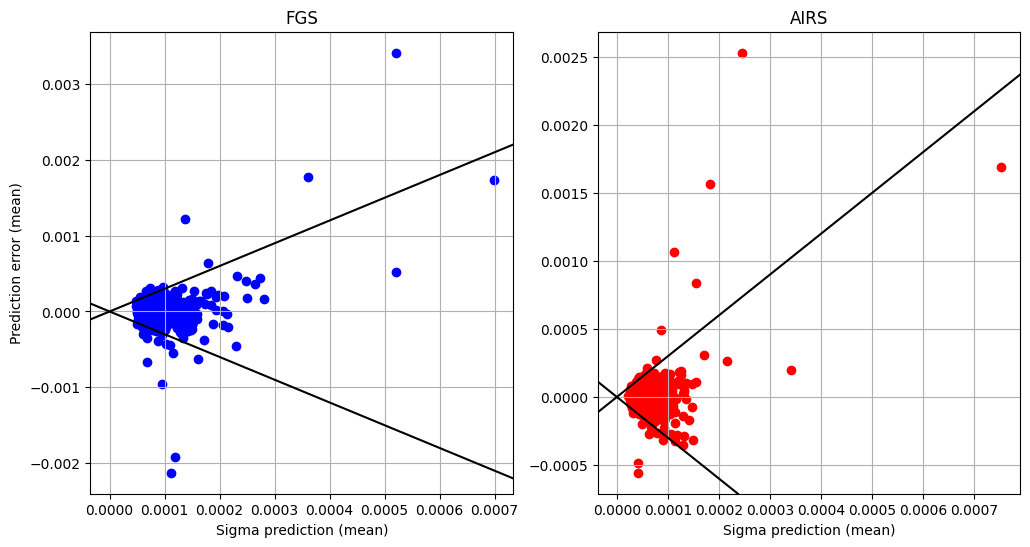

AIRS variation
1349926825, ratio:10.892, x:9.391e-05, y:1.023e-03, RMS:1.043e-03
2270815333, ratio:10.692, x:8.714e-05, y:9.318e-04, RMS:1.047e-03
2740910036, ratio:5.408, x:1.545e-05, y:8.355e-05, RMS:8.375e-05
926530491, ratio:4.406, x:1.594e-05, y:7.023e-05, RMS:1.162e-04
1843015807, ratio:4.046, x:1.603e-05, y:6.484e-05, RMS:1.688e-03
3786449677, ratio:4.005, x:1.096e-04, y:4.391e-04, RMS:5.515e-04
2364090646, ratio:3.598, x:1.609e-05, y:5.789e-05, RMS:2.950e-04
3196466205, ratio:3.476, x:1.527e-05, y:5.306e-05, RMS:9.978e-05
1470836017, ratio:3.316, x:8.566e-05, y:2.840e-04, RMS:2.843e-04
2617217319, ratio:3.246, x:1.583e-05, y:5.138e-05, RMS:5.250e-05


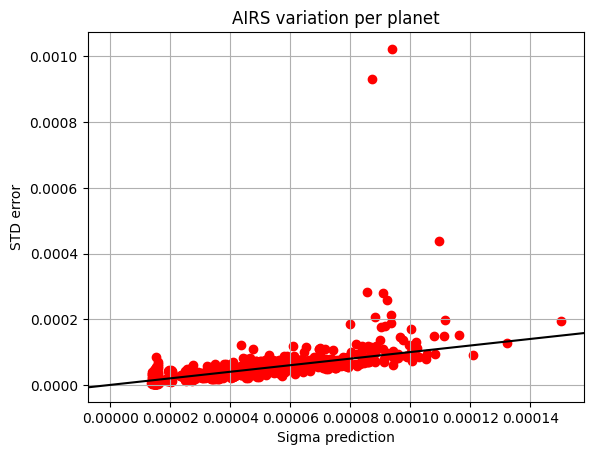

New FGS mf+ poly FGS
[1.0003578274412868, 0.9983433492554453]
[-1.399812560065723e-06, 6.598273548574043e-06]
[2.2445037987733847, 1.3432005762971653]
Score:          0.6071
RMS error FGS:  228.79 ppm
RMS error AIRS: 173.51 ppm

20
Score:          0.6301
RMS error FGS:  85.02 ppm
RMS error AIRS: 69.56 ppm

No fudge
Score:          0.5737
RMS error FGS:  228.79 ppm
RMS error AIRS: 173.51 ppm


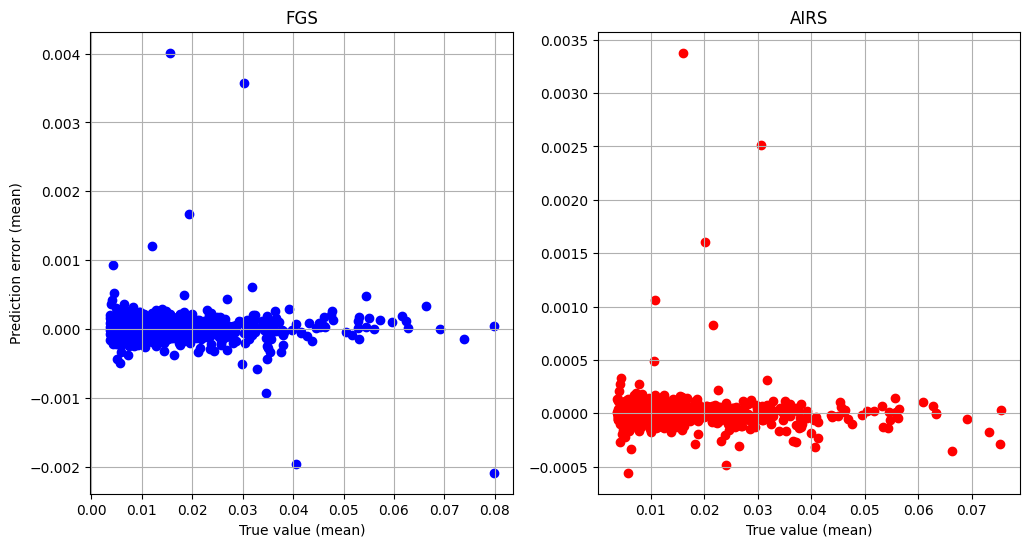

FGS
3786449677, ratio:26.654, x:7.368e-05, y:-1.964e-03, RMS:5.509e-04
1349926825, ratio:26.506, x:7.867e-05, y:-2.085e-03, RMS:1.043e-03
1267010874, ratio:15.900, x:5.847e-05, y:-9.296e-04, RMS:3.289e-04
94572221, ratio:13.205, x:3.779e-05, y:-4.990e-04, RMS:5.566e-04
2554492145, ratio:12.730, x:9.497e-05, y:1.209e-03, RMS:1.077e-03
2498341557, ratio:8.266, x:4.524e-05, y:-3.739e-04, RMS:1.219e-04
3649218579, ratio:7.546, x:4.735e-04, y:3.573e-03, RMS:2.520e-03
342072318, ratio:6.738, x:4.679e-05, y:-3.153e-04, RMS:1.045e-04
4121191674, ratio:6.507, x:4.734e-05, y:-3.081e-04, RMS:1.280e-04
4233843352, ratio:6.262, x:3.520e-05, y:-2.205e-04, RMS:8.751e-05
AIRS
94572221, ratio:13.053, x:4.265e-05, y:-5.567e-04, RMS:5.566e-04
3649218579, ratio:11.074, x:2.270e-04, y:2.514e-03, RMS:2.520e-03
2270815333, ratio:10.943, x:4.400e-05, y:-4.815e-04, RMS:1.047e-03
2554492145, ratio:9.921, x:1.074e-04, y:1.066e-03, RMS:1.077e-03
576917580, ratio:8.803, x:1.818e-04, y:1.600e-03, RMS:1.602e-03
3467

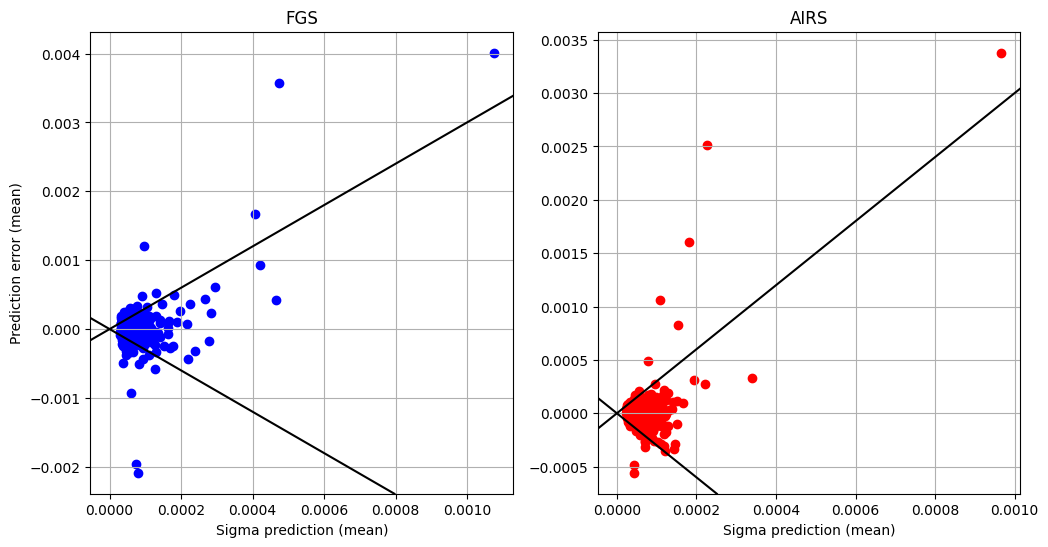

AIRS variation
1349926825, ratio:10.784, x:9.485e-05, y:1.023e-03, RMS:1.043e-03
2270815333, ratio:10.638, x:8.759e-05, y:9.318e-04, RMS:1.047e-03
926530491, ratio:4.418, x:1.589e-05, y:7.021e-05, RMS:1.213e-04
1843015807, ratio:4.080, x:1.588e-05, y:6.481e-05, RMS:3.381e-03
3786449677, ratio:4.048, x:1.084e-04, y:4.389e-04, RMS:5.509e-04
2364090646, ratio:3.646, x:1.588e-05, y:5.789e-05, RMS:2.986e-04
2617217319, ratio:3.475, x:1.478e-05, y:5.138e-05, RMS:5.205e-05
1329658345, ratio:3.426, x:1.441e-05, y:4.938e-05, RMS:1.020e-04
1470836017, ratio:3.286, x:8.644e-05, y:2.840e-04, RMS:2.842e-04
3098975946, ratio:3.165, x:1.521e-05, y:4.814e-05, RMS:6.495e-05


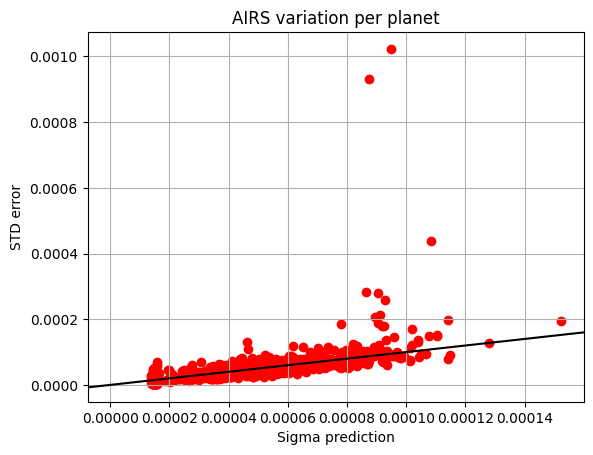

In [9]:
ignore_bad_planets = False
def filter_bad_data(data):
    data_out = []
    for d in data:
        if not d.planet_id in [1349926825, 3786449677, 2554492145, 1267010874, 94572221, 2270815333, 3649218579, 576917580, 2154305089, 2207815333, 2740910036]:
            data_out.append(d)
    return data_out
        
def basics():
    plt.grid(True)
    plt.box(True)
def plot_two_sensors(func, xl, yl, mod):
    _,ax = plt.subplots(1,2,figsize=(12,6))
    plt.sca(ax[0]);basics()
    plt.title('FGS')
    plt.xlabel(xl)
    plt.ylabel(yl)
    func(slice(0,1), 'blue', 'FGS')
    mod()
    
    plt.sca(ax[1]);basics()
    plt.title('AIRS')
    plt.xlabel(xl)
    func(slice(1,283), 'red', 'AIRS')
    mod()
    
    plt.pause(0.001)

def report_extreme_ratios(x,y,name):
    print(name)
    inds = np.argsort(np.abs(y/x))[::-1]
    for ii in inds[:10]:
        print(f'{inferred_data[ii].planet_id}, ratio:{np.abs(y[ii]/x[ii]):.3f}, x:{x[ii]:.3e}, y:{y[ii]:.3e}, RMS:{kgs.rms(error_matrix[ii,:]):.3e}')
    
    
for k,v in todo.items():
    (inferred_data,model,_) = kgs.dill_load(fname(k))
    if ignore_bad_planets:
        inferred_data = filter_bad_data(inferred_data)
        train_data_here = filter_bad_data(train_data)
    else:
        train_data_here = train_data
    #model.bias_a[0]+=0.006
    #model.bias_a[1]-=0.0002
    #inferred_data = model.infer(train_data)
    print(k)
    print(model.bias_a)
    print(model.bias_b)
    print(model.sigma_fudge)
    kgs.score_metric(inferred_data, train_data_here)
    print('')
    print('20')
    kgs.score_metric(inferred_data[:20], train_data_here[:20]) 
    print('')
    print('No fudge')
    model.sigma_fudge = [1,1]
    #model.bias_a = [1,1]
    #model.bias_b = [0,0]
    # print('!!!')
    inferred_data = model.infer(train_data)
    if ignore_bad_planets:
        inferred_data = filter_bad_data(inferred_data)
    kgs.score_metric(inferred_data, train_data_here)     
    error_matrix = np.array([d.spectrum - t.spectrum for d,t in zip(inferred_data,train_data_here)])
    true_matrix = np.array([t.spectrum for d,t in zip(inferred_data,train_data_here)])
    
    def plot_prediction_vs_true(slic, col, name):
        x = np.mean(true_matrix[:,slic],1)
        y = np.mean(error_matrix[:,slic],1)
        plt.scatter(x,y,color = col)
        
    plot_two_sensors(plot_prediction_vs_true, 'True value (mean)', 'Prediction error (mean)', lambda:0)
    
    def plot_mean_error_vs_sigma(slic,col, name):
        x = [np.sqrt(np.sum(d.spectrum_cov[slic,slic])/(slic.stop-slic.start)**2) for d in inferred_data]
        y = np.mean(error_matrix[:,slic],1)
        plt.scatter(x,y,color = col)
        report_extreme_ratios(x,y,name)
    def mod():
        plt.axline((0,0), slope=3, color='black')
        plt.axline((0,0), slope=-3, color = 'black')        
    plot_two_sensors(plot_mean_error_vs_sigma, 'Sigma prediction (mean)', 'Prediction error (mean)', mod)
    
    plt.figure(); basics()
    plt.title('AIRS variation per planet')
    plt.xlabel('Sigma prediction')
    plt.ylabel('STD error')
    n=282
    x=np.sqrt([(np.trace(d.spectrum_cov[1:,1:]) - np.sum(d.spectrum_cov[1:,1:]) / n) / n for d in inferred_data])
    y=np.sqrt(np.var(error_matrix[:,1:],1))
    plt.scatter(x, y, color='red')
    plt.axline((0,0), slope=1, color='black')
    report_extreme_ratios(x,y,'AIRS variation')    
    plt.pause(0.001)

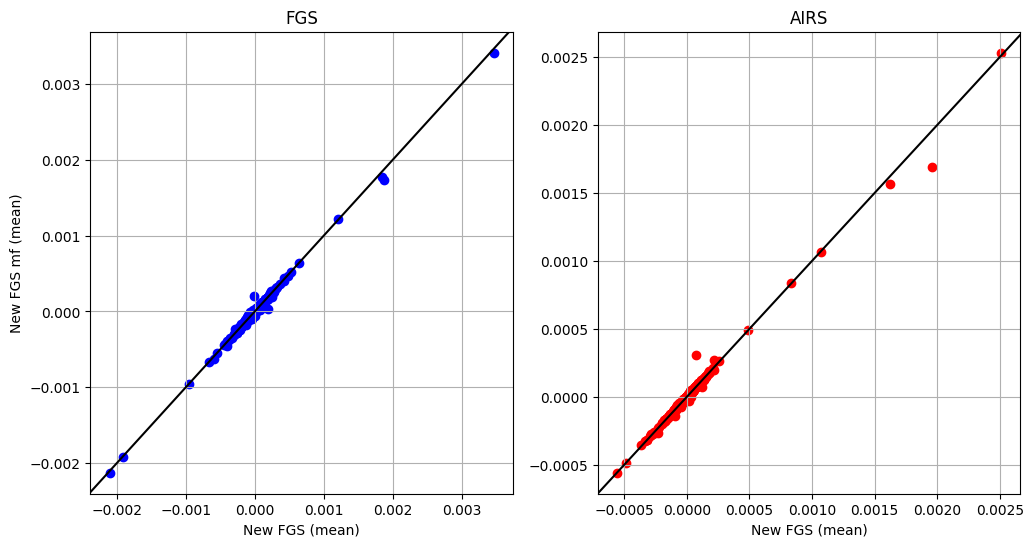

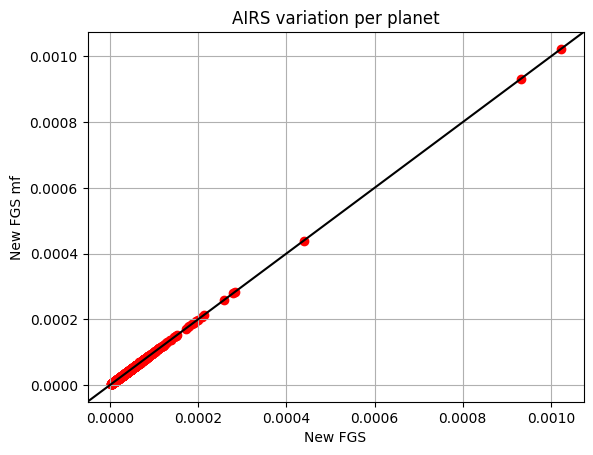

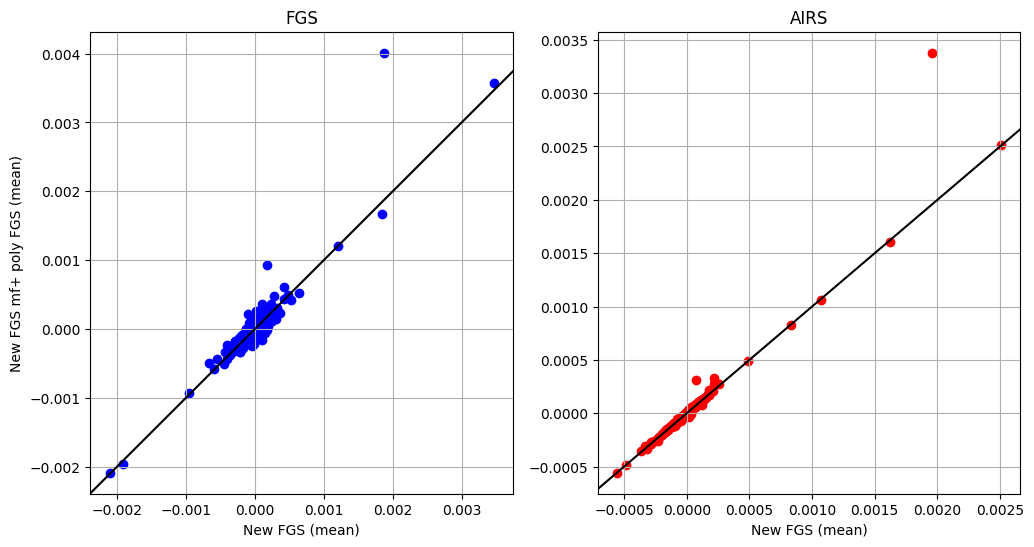

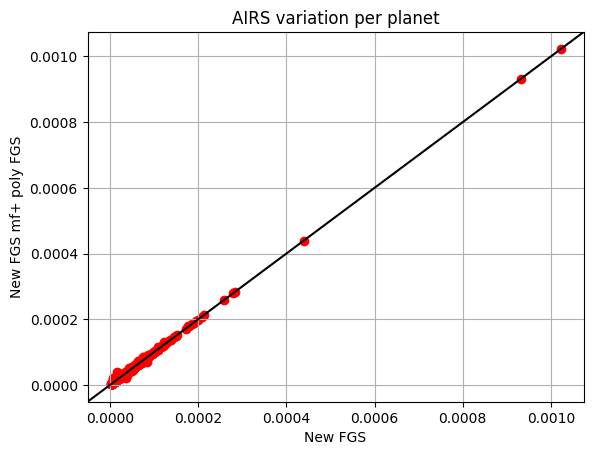

In [10]:
compare1= list(todo.keys())[0]
data1 = kgs.dill_load(fname(compare1))[0]
if ignore_bad_planets:
    data1 = filter_bad_data(data1)
for k,v in todo.items():    
    compare2= k
    if compare2==compare1:
        continue    
    data2 = kgs.dill_load(fname(compare2))[0]
    if ignore_bad_planets:
        data2 = filter_bad_data(data2)
        train_data_here = filter_bad_data(train_data)
    else:
        train_data_here = train_data           
    error1 = np.array([d.spectrum - t.spectrum for d,t in zip(data1,train_data_here)])
    error2 = np.array([d.spectrum - t.spectrum for d,t in zip(data2,train_data_here)])
    def plot_prediction_vs_true(slic, col, name):
        x = np.mean(error1[:,slic],1)
        y = np.mean(error2[:,slic],1)
        plt.scatter(x,y,color = col)

    plot_two_sensors(plot_prediction_vs_true, compare1+' (mean)', compare2+' (mean)', lambda:plt.axline((0,0),slope=1,color='black'))

    plt.figure(); basics()
    plt.title('AIRS variation per planet')
    plt.xlabel(compare1)
    plt.ylabel(compare2)
    x=np.sqrt(np.var(error1[:,1:],1))
    y=np.sqrt(np.var(error2[:,1:],1))
    plt.scatter(x, y, color='red')
    plt.axline((0,0), slope=1, color='black')
    plt.pause(0.001)

In [7]:
import subprocess

# Hibernate Windows
subprocess.run(
    ["/mnt/c/Windows/System32/shutdown.exe", "/h"],  # add "/f" to force-close apps
    check=True
)

CompletedProcess(args=['/mnt/c/Windows/System32/shutdown.exe', '/h'], returncode=0)